In [344]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import time
from raven import Client

## Acquisition

In [216]:
data = pd.read_csv('./data/FAO.csv', encoding='latin1')
data.head()

,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,AFG,2,Afghanistan,2511,Wheat and products,5142,Food,1000 tonnes,33.94,67.71,...,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,AFG,2,Afghanistan,2805,Rice (Milled Equivalent),5142,Food,1000 tonnes,33.94,67.71,...,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,AFG,2,Afghanistan,2513,Barley and products,5521,Feed,1000 tonnes,33.94,67.71,...,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,AFG,2,Afghanistan,2513,Barley and products,5142,Food,1000 tonnes,33.94,67.71,...,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,AFG,2,Afghanistan,2514,Maize and products,5521,Feed,1000 tonnes,33.94,67.71,...,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


In [217]:
data.shape

(21477, 63)

## Wrangling
Consultamos la información del dataframe

In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21477 entries, 0 to 21476
Data columns (total 63 columns):
Area Abbreviation    21477 non-null object
Area Code            21477 non-null int64
Area                 21477 non-null object
Item Code            21477 non-null int64
Item                 21477 non-null object
Element Code         21477 non-null int64
Element              21477 non-null object
Unit                 21477 non-null object
latitude             21477 non-null float64
longitude            21477 non-null float64
Y1961                17938 non-null float64
Y1962                17938 non-null float64
Y1963                17938 non-null float64
Y1964                17938 non-null float64
Y1965                17938 non-null float64
Y1966                17938 non-null float64
Y1967                17938 non-null float64
Y1968                17938 non-null float64
Y1969                17938 non-null float64
Y1970                17938 non-null float64
Y1971                1

### Wrangling - Analizamos los nulos del dataframe

Analizamos los nulos

In [219]:
def nulos(dataframe):
    null_cols = dataframe.isnull().sum()
    return null_cols[null_cols > 0]

data_nulos = nulos(data)
print(data_nulos)

Y1961    3539
Y1962    3539
Y1963    3539
Y1964    3539
Y1965    3539
Y1966    3539
Y1967    3539
Y1968    3539
Y1969    3539
Y1970    3539
Y1971    3539
Y1972    3539
Y1973    3539
Y1974    3539
Y1975    3539
Y1976    3539
Y1977    3539
Y1978    3539
Y1979    3539
Y1980    3539
Y1981    3539
Y1982    3539
Y1983    3539
Y1984    3539
Y1985    3539
Y1986    3539
Y1987    3539
Y1988    3539
Y1989    3539
Y1990    3415
Y1991    3415
Y1992     987
Y1993     612
Y1994     612
Y1995     612
Y1996     612
Y1997     612
Y1998     612
Y1999     612
Y2000     349
Y2001     349
Y2002     349
Y2003     349
Y2004     349
Y2005     349
Y2006     104
Y2007     104
Y2008     104
Y2009     104
Y2010     104
Y2011     104
dtype: int64


### Renombramos las columnas de los años para que nos sea más fácil gestionar los nulos

In [220]:
#Vemos que los nulos están en las columnas de años pero no son demasiados
#y son referentes a paises que esa fecha no existian
#así que los convertimos en ceros

#Podemos ver que las columnas comienzan con 'Y', vamos a elimminar 
#este caracter para que la columna sea unicamente el año.

def renombra_columnas_year(c):
    if len(c) > 4:
        if re.match('^(?=.*[0-9])', c):
            return c[1:]
        else:
            return c
    else:
        return c

data_columns = [renombra_columnas_year(c) for c in data.columns]
data.columns = data_columns

También renombro la columna Area Abbreviation, la cual utilizaremos posteriormente

In [221]:
data = data.rename(columns = {'Area Abbreviation' : 'Area_ISO'})

Procesamos los valors nulos

In [222]:
#Prcesamos los nulos
columnas = range(1961,2014)

for x in columnas:
    data[str(x)] = data[str(x)].fillna(0)


In [223]:
nulos(data)

Series([], dtype: int64)

In [224]:
print(data.columns)

Index(['Area_ISO', 'Area Code', 'Area', 'Item Code', 'Item', 'Element Code',
       'Element', 'Unit', 'latitude', 'longitude', '1961', '1962', '1963',
       '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972',
       '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990',
       '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013'],
      dtype='object')


### Identificamos si existen columnas con baja varianza

In [225]:
low_variance = []

for col in data._get_numeric_data():
    minimum = min(data[col])
    ninety_perc = np.percentile(data[col], 90)
    if ninety_perc == minimum:
        low_variance.append(col)

print(low_variance)

[]


### Wrangling - Borramos columnas que no vamos a necesitar

In [275]:
nueva_data = data.drop(['Item Code', 'Element Code', 'Unit'], axis=1)

nueva_data.head()

,Area_ISO,Area Code,Area,Item,Element,latitude,longitude,1961,1962,1963,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,AFG,2,Afghanistan,Wheat and products,Food,33.94,67.71,1928.0,1904.0,1666.0,...,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,AFG,2,Afghanistan,Rice (Milled Equivalent),Food,33.94,67.71,183.0,183.0,182.0,...,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,AFG,2,Afghanistan,Barley and products,Feed,33.94,67.71,76.0,76.0,76.0,...,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,AFG,2,Afghanistan,Barley and products,Food,33.94,67.71,237.0,237.0,237.0,...,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,AFG,2,Afghanistan,Maize and products,Feed,33.94,67.71,210.0,210.0,214.0,...,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


### Wrangling - Analizamos los valores de las columnas en busca de datos incorrectos

In [276]:
#nueva_data['Area'].value_counts()
#nueva_data['Area'].value_counts()
#nueva_data['Item'].value_counts()
nueva_data['Element'].value_counts()

Food    17528
Feed     3949
Name: Element, dtype: int64

In [277]:
def remover_duplicados(dataframe, columnas = []):
    antes = len(dataframe)
    dataframe = dataframe[columnas].drop_duplicates()
    despues = len(dataframe)
    total = antes - despues
    print('Registros duplicados eliminados: {}'.format(total))
    return dataframe

temporal = remover_duplicados(data)

Registros duplicados eliminados: 0


## Vamos a añadir valores a nuestro dataframe
Añadiremos el continente al que pertenece cada área, para ellos utilizaremos una api
Para realizar la petición a la api utilizamos la columna **'Area_ISO'** que nos proporciona el código de la zona

In [254]:
def devuelve_continente(area):
    #Devuelve el continente al que pertenece el area
    try: 
        url_iso = 'https://restcountries.eu/rest/v2/alpha/'
        peticion = url_iso + area
        res_continente = requests.get(peticion)
        results = res_continente.json()
        return results['region']

    except Exception as e:
        return 'Error: ' + str(e)
    
#Para no realizar un a petición por fila obtenemos los diferentes valores para la columna Area_ISO
areas = set(nueva_data['Area_ISO'])
area_continente = {}

for area in areas:
    area_continente[area] = devuelve_continente(area)
    time.sleep(1)
    
area_continente

{'PAK': 'Asia',
 'FRA': 'Europe',
 'ITA': 'Europe',
 'EST': 'Europe',
 'IRL': 'Europe',
 'IRN': 'Asia',
 'SWE': 'Europe',
 'MUS': 'Africa',
 'BIH': 'Europe',
 'SEN': 'Africa',
 'AGO': 'Africa',
 'EGY': 'Africa',
 'SLB': 'Oceania',
 'MLI': 'Africa',
 'JPN': 'Asia',
 'NIC': 'Americas',
 'SLE': 'Africa',
 'GNB': 'Africa',
 'LBR': 'Africa',
 'MDA': 'Europe',
 'LVA': 'Europe',
 'TZA': 'Africa',
 'TUR': 'Asia',
 'ATG': 'Americas',
 'TLS': 'Asia',
 'VNM': 'Asia',
 'CIV': 'Africa',
 'BEL': 'Europe',
 'DOM': 'Americas',
 'LKA': 'Asia',
 'KWT': 'Asia',
 'MNE': 'Europe',
 'HUN': 'Europe',
 'IND': 'Asia',
 'AFG': 'Asia',
 'ISR': 'Asia',
 'RUS': 'Europe',
 'COD': 'Africa',
 'NZL': 'Oceania',
 'MNG': 'Asia',
 'STP': 'Africa',
 'MWI': 'Africa',
 'MDV': 'Asia',
 'MAR': 'Africa',
 'VCT': 'Americas',
 'ALB': 'Europe',
 'NCL': 'Oceania',
 'VEN': 'Americas',
 'WSM': 'Oceania',
 'LSO': 'Africa',
 'SDN': 'Africa',
 'NAM': 'Africa',
 'BLR': 'Europe',
 'AZE': 'Asia',
 'NLD': 'Europe',
 'POL': 'Europe',
 'ZWE'

In [247]:
nueva_data['Area_ISO'][0]

'AFG'

In [278]:
nueva_data['Continente'] = nueva_data['Area_ISO'].apply(lambda x : area_continente[x])

In [279]:
nueva_data

,Area_ISO,Area Code,Area,Item,Element,latitude,longitude,1961,1962,1963,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Continente
0,AFG,2,Afghanistan,Wheat and products,Food,33.94,67.71,1928.0,1904.0,1666.0,...,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895,Asia
1,AFG,2,Afghanistan,Rice (Milled Equivalent),Food,33.94,67.71,183.0,183.0,182.0,...,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422,Asia
2,AFG,2,Afghanistan,Barley and products,Feed,33.94,67.71,76.0,76.0,76.0,...,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360,Asia
3,AFG,2,Afghanistan,Barley and products,Food,33.94,67.71,237.0,237.0,237.0,...,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89,Asia
4,AFG,2,Afghanistan,Maize and products,Feed,33.94,67.71,210.0,210.0,214.0,...,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200,Asia
5,AFG,2,Afghanistan,Maize and products,Food,33.94,67.71,403.0,403.0,410.0,...,67.0,82.0,67.0,69.0,71.0,82.0,73.0,77,76,Asia
6,AFG,2,Afghanistan,Millet and products,Food,33.94,67.71,17.0,18.0,19.0,...,21.0,11.0,19.0,21.0,18.0,14.0,14.0,14,12,Asia
7,AFG,2,Afghanistan,"Cereals, Other",Food,33.94,67.71,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,Asia
8,AFG,2,Afghanistan,Potatoes and products,Food,33.94,67.71,111.0,97.0,103.0,...,294.0,294.0,260.0,242.0,250.0,192.0,169.0,196,230,Asia
9,AFG,2,Afghanistan,Sugar cane,Feed,33.94,67.71,45.0,45.0,45.0,...,29.0,61.0,65.0,54.0,114.0,83.0,83.0,69,81,Asia


In [280]:
set(nueva_data['Continente']) #Comprobando que este correcto

{'Africa', 'Americas', 'Asia', 'Europe', 'Oceania'}

## Analysis

Para el análisis vamos a tomar los alimentos para humanos y realizaremos comparativa por continentes

In [310]:
datos_analisis = nueva_data[nueva_data['Element'] == 'Food'].copy()
datos_analisis.head()

,Area_ISO,Area Code,Area,Item,Element,latitude,longitude,1961,1962,1963,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Continente
0,AFG,2,Afghanistan,Wheat and products,Food,33.94,67.71,1928.0,1904.0,1666.0,...,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895,Asia
1,AFG,2,Afghanistan,Rice (Milled Equivalent),Food,33.94,67.71,183.0,183.0,182.0,...,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422,Asia
3,AFG,2,Afghanistan,Barley and products,Food,33.94,67.71,237.0,237.0,237.0,...,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89,Asia
5,AFG,2,Afghanistan,Maize and products,Food,33.94,67.71,403.0,403.0,410.0,...,67.0,82.0,67.0,69.0,71.0,82.0,73.0,77,76,Asia
6,AFG,2,Afghanistan,Millet and products,Food,33.94,67.71,17.0,18.0,19.0,...,21.0,11.0,19.0,21.0,18.0,14.0,14.0,14,12,Asia


In [266]:
datos_analisis.shape

(17528, 61)

Vamos a tomar el total producido en los años cotemplados en los datos por pais

In [364]:
datos_analisis['Total'] = datos_analisis[nueva_data.columns[7:60]].sum(axis=1)

#Borramos las columnas de los años y nos quedamos con el total
datos_total = datos_analisis.drop(nueva_data.columns[7:60], axis=1)
datos_total.head()

,Area_ISO,Area Code,Area,Item,Element,latitude,longitude,Continente,Total
0,AFG,2,Afghanistan,Wheat and products,Food,33.94,67.71,Asia,132926.0
1,AFG,2,Afghanistan,Rice (Milled Equivalent),Food,33.94,67.71,Asia,15282.0
3,AFG,2,Afghanistan,Barley and products,Food,33.94,67.71,Asia,8529.0
5,AFG,2,Afghanistan,Maize and products,Food,33.94,67.71,Asia,15216.0
6,AFG,2,Afghanistan,Millet and products,Food,33.94,67.71,Asia,1180.0


In [331]:
total_produccion_pais = datos_total.groupby(['Area']).Total.sum()
total_produccion_pais.sort_values(ascending = False)[:5]

Area
China, mainland             60723839.0
India                       34570279.0
United States of America    26227192.0
Brazil                       9393856.0
Germany                      7977690.0
Name: Total, dtype: float64

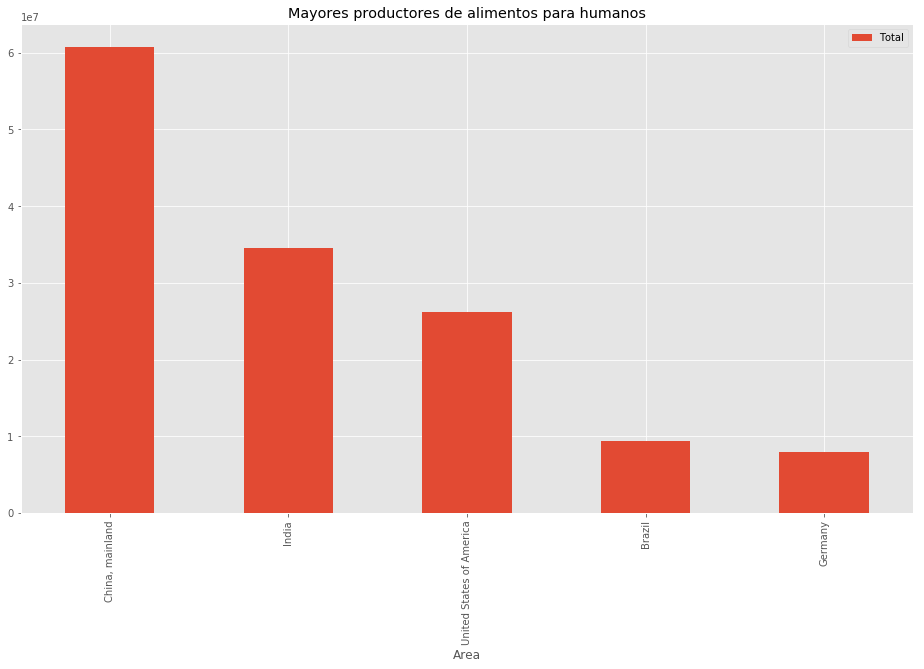

In [350]:
mayores_productores = total_produccion_pais.sort_values(ascending = False)[:5]
mayores_productores_bar = mayores_productores.plot(kind = 'bar', title = "Mayores productores de alimentos para humanos", legend = True, use_index=True, figsize=(16,9))

In [351]:
total_produccion_continente = datos_total.groupby(['Continente']).Total.sum()
total_produccion_continente.sort_values(ascending = False)

Continente
Asia        150828245.0
Americas     55928968.0
Europe       53351142.0
Africa       29232065.0
Oceania       2034943.0
Name: Total, dtype: float64

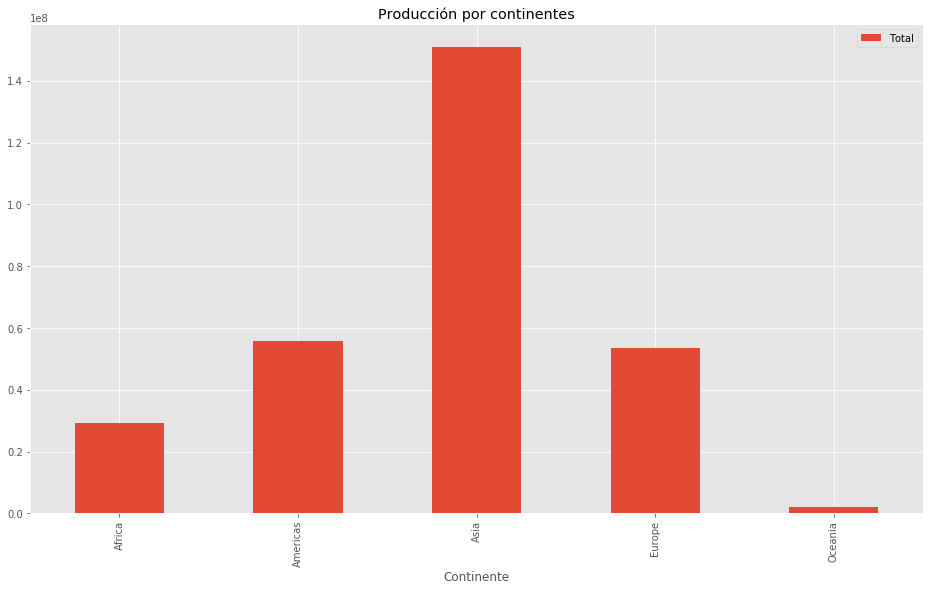

In [349]:
mayores_productores_bar = total_produccion_continente.plot(kind = 'bar', title = "Producción por continentes", legend = True, use_index=True, figsize=(16,9))

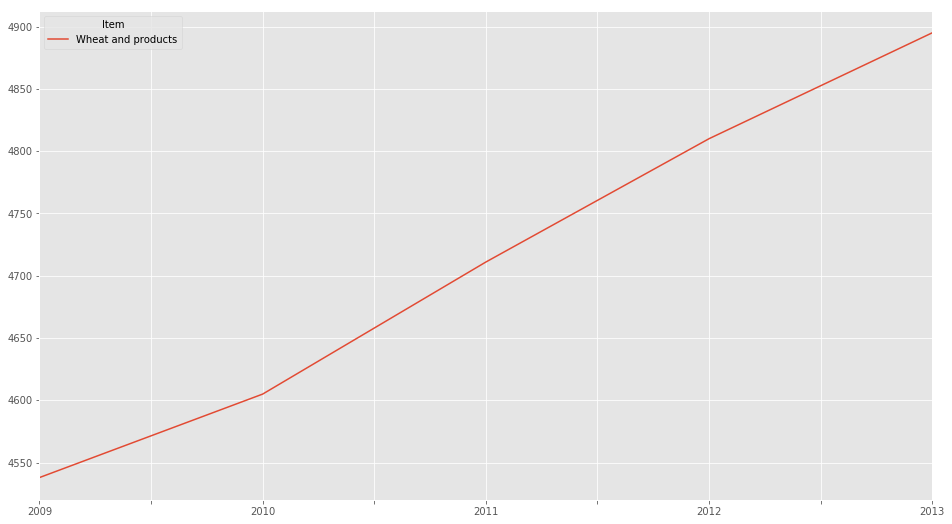

In [433]:
def report_pais(pais, item):
    report = datos_analisis[['Item', '2009', '2010', '2011', '2012', '2013']][(datos_analisis['Area'] == pais) & (datos_analisis['Item'] == item)]
    report = report.set_index('Item')
    title = '{} ({})'.format(pais,item)
    #chart = f.plot(kind = 'line', title = title, legend = True, figsize=(16,9))
    return report.T


f = report_pais('Afghanistan', 'Wheat and products')
f
chart = f.plot(kind = 'line', title = '', legend = True, figsize=(16,9))

## Reporting

In [432]:
def save_viz(chart, title):
    fig = chart.get_figure()
    fig.savefig(title + '.png')
    
save_viz(chart, 'Prueba') 